In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import integrate
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import Constant, Linear, DenseNet, NN, NN_Nik, SingleParam, MySequential
from problems import DoubleWell, DoubleWell_multidim, DoubleWell_OU, LQGC, LLGC, DoubleWell_multidim
from solver import Solver
from utilities import do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [2]:
d = 10

def integrand(x):
    return np.exp(2 / d * np.cos(x))

np.sqrt(integrate.quad(integrand, 0, 2 * np.pi)[0]**d / (2 * np.pi)**d)

1.0511402766738196

In [3]:
def hat_function(x):
    return pt.exp(-200 * x**2) * ((x > -0.2) & (x < 0.2))

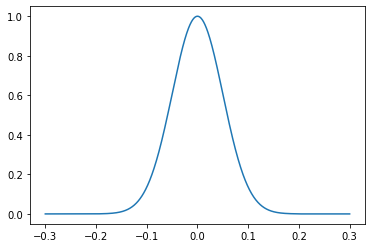

In [4]:
plt.plot(pt.linspace(-0.3, 0.3, 1000), hat_function(pt.linspace(-0.3, 0.3, 1000)));

In [5]:
class DenseNet_2(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet_2, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.layers = pt.nn.ModuleList([pt.nn.Linear(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1])
                                        for i in range(len(self.nn_dims) - 1)])   
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        self.relu = pt.nn.ReLU()

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = self.layers[i](x)
            else:
                x = pt.cat([x, pt.nn.functional.tanh(self.layers[i](x))], dim=1)
        return x
    
class SingleParam(pt.nn.Module):
    def __init__(self, lr, initial=None, seed=42):
        super(SingleParam, self).__init__()
        pt.manual_seed(seed)
        if initial is None:
            self.Y_0 = pt.nn.Parameter(pt.tensor([0.0]), requires_grad=True)
        elif initial == 'random':
            self.Y_0 = pt.nn.Parameter(pt.randn(1), requires_grad=True)
        else:
            self.Y_0 = pt.nn.Parameter(pt.tensor([initial]), requires_grad=True)

        self.register_parameter('param', self.Y_0)
        self.optim = pt.optim.Adam(self.parameters(), lr=lr)
        #self.optim = pt.optim.SGD(self.parameters(), lr=lr)

    def forward(self, x):
        return self.Y_0
    
class DenseNet(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[pt.nn.Parameter(pt.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.1),
                    pt.nn.Parameter(0.1 * pt.ones(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]
        self.relu = pt.nn.ReLU()
        self.sigmoid = pt.nn.Sigmoid()

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = pt.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = pt.cat([x, pt.nn.functional.relu(pt.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return x
    

    
class DenseNet_relu(pt.nn.Module):
    def __init__(self, d_in, d_out, lr, arch=[30, 30], seed=42):
        super(DenseNet_relu, self).__init__()
        pt.manual_seed(seed)
        self.nn_dims = [d_in] + arch + [d_out]
        self.W = [item for sublist in
                  [[pt.nn.Parameter(pt.randn(sum(self.nn_dims[:i + 1]), self.nn_dims[i + 1],
                                             requires_grad=True) * 0.01 + 0.01),
                    pt.nn.Parameter(0.1 * pt.ones(self.nn_dims[i + 1], requires_grad=True))] for
                   i in range(len(self.nn_dims) - 1)]
                  for item in sublist]
        self.relu = pt.nn.ReLU()
        self.sigmoid = pt.nn.Sigmoid()

        for i, w in enumerate(self.W):
            self.register_parameter('param %d' % i, w)

        self.optim = pt.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        for i in range(len(self.nn_dims) - 1):
            if i == len(self.nn_dims) - 2:
                x = pt.matmul(x, self.W[2 * i]) + self.W[2 * i + 1]
            else:
                x = pt.cat([x, pt.nn.functional.relu(pt.matmul(x, self.W[2 * i])
                                                     + self.W[2 * i + 1]) ** 2], dim=1)
        return pt.nn.functional.relu(x)

In [6]:
class Eigenvalue():
    def __init__(self, name='Eigenvalue', d=1):
        self.name = name
        self.d = d
        self.c = 1.0511402766738196
        self.B = (pt.sqrt(pt.tensor(2.0)) * pt.eye(self.d)).to(device)
        self.X_0 = pt.tensor(np.pi) * pt.ones(self.d).to(device)
        self.Y_0 = pt.zeros(1).to(device)
        self.lambda_ = -3.0
        self.X_l = 0.0
        self.X_r = 2 * np.pi

    def b(self, x):
        return pt.zeros(x.shape).to(device)

    def sigma(self, x):
        return self.B

    def g(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return pt.zeros(x.shape[0]).to(device)

    def h(self, x, y, z):
        return -y**3 - y * (-1 / self.c**2 * pt.exp(2 / self.d * pt.sum(pt.cos(x), 1)) 
                            + pt.sum((pt.sin(x)**2 / self.d**2 - pt.cos(x) / self.d), 1) - 3)
   
    #def u_true(self, x):
    #    return -self.B * pt.tensor(np.pi) * pt.cos(pt.tensor(np.pi) * x)
   
    def v_true(self, x):
        #return pt.exp(self.alpha * pt.sqrt(pt.sum(x**2, 1)))
        return 1 / self.c * pt.exp(1 / self.d * pt.sum(pt.cos(x), 1))

In [9]:
d = 10

problem = Eigenvalue(d=d)

V = DenseNet_relu(d, 1, lr=0.001, arch=[15, 15, 15, 15]).to(device)
lambda_ = SingleParam(initial=-2.0, lr=0.001).to(device)

In [10]:
alpha = [50.0, 1.0]

L = 200000
N = 20
K = 500
K_boundary = 50
print_every = 100
delta_t = pt.tensor([0.001]).to(device)
delta_t_np = delta_t.cpu().numpy()
sq_delta_t = pt.sqrt(delta_t)

adaptive_forward_process = False
detach_forward = True

loss_log = []
loss_log_boundary = []
loss_log_derivative_boundary = []
loss_log_domain = []
loss_log_center = []
V_L2_log = []
times = []
y_0_log = []
lambda_log = []

for l in range(L):

    t_0 = time.time()

    loss = 0

    #X_center = 0.5 * pt.ones(1, d) # problem.X_0.repeat(1, 1).to(device)
    #loss += pt.mean((V(X_center).squeeze() - problem.v_true(X_center).squeeze())**2)

    X_2 = (problem.X_r - problem.X_l) * pt.rand(K, problem.d).to(device) + problem.X_l
    
    loss += 1.0 * hat_function(pt.mean(V(X_2).squeeze()**2))
    
    loss += 0.01 * (pt.mean(V(X_2).squeeze()**2) - 1)**2
    
    loss_log_center.append(0.01 * ((pt.mean(V(X_2).squeeze()**2) - 1)**2).item())

    # sample uniformly on boundary
    s = np.concatenate([np.ones(int(K_boundary / 2))[:, np.newaxis], np.zeros([int(K_boundary / 2), d - 1])], 1)
    np.apply_along_axis(np.random.shuffle, 1, s)
    a = np.concatenate([s, np.zeros([int(K_boundary / 2), problem.d])]).astype(bool)
    b = np.concatenate([np.zeros([int(K_boundary / 2), problem.d]), s]).astype(bool)
    X_boundary = (problem.X_r - problem.X_l) * pt.rand(K_boundary, problem.d).to(device) + problem.X_l
    X_boundary_reflect = copy.deepcopy(X_boundary)
    X_boundary[pt.tensor(a.astype(float)).bool()] = problem.X_l
    X_boundary_reflect[pt.tensor(a.astype(float)).bool()] = problem.X_r
    X_boundary[pt.tensor(b.astype(float)).bool()] = problem.X_r
    X_boundary_reflect[pt.tensor(b.astype(float)).bool()] = problem.X_l

    loss += alpha[1] * pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2)
    loss_log_boundary.append(pt.mean((V(X_boundary).squeeze() - V(X_boundary_reflect).squeeze())**2).item())
    
    X_boundary = pt.autograd.Variable(X_boundary, requires_grad=True)
    X_boundary_reflect = pt.autograd.Variable(X_boundary_reflect, requires_grad=True)

    Y_reflect = V(X_boundary_reflect)
    Y_eval_reflect = Y_reflect.squeeze().sum()
    Y_eval_reflect.backward(retain_graph=True)
    grad_V_reflect, = pt.autograd.grad(Y_eval_reflect, X_boundary_reflect, create_graph=True)

    Y_ = V(X_boundary)
    Y_eval = Y_.squeeze().sum()
    Y_eval.backward(retain_graph=True)
    grad_V, = pt.autograd.grad(Y_eval, X_boundary, create_graph=True)
    
    loss += alpha[1] * pt.mean((grad_V - grad_V_reflect)**2)
    loss_log_derivative_boundary.append( pt.mean((grad_V - grad_V_reflect)**2).item())

    X = (problem.X_r - problem.X_l) * pt.rand(K, problem.d).to(device) + problem.X_l

    X = pt.autograd.Variable(X, requires_grad=True)
    Y = pt.zeros(K).to(device)

    #lambda_log.append(lambda_(X)[0].item())
    stopped = pt.zeros(K).bool().to(device)
    hitting_times = pt.zeros(K)
    V_L2 = pt.zeros(K)

    phi_0 = V(X).squeeze()

    for n in range(N):

        Y_ = V(X)
        Y_eval = Y_.squeeze().sum()
        Y_eval.backward(retain_graph=True)
        Z, = pt.autograd.grad(Y_eval, X, create_graph=True)
        Z = pt.mm(problem.sigma(X).t(), Z.t()).t()

        xi = pt.randn(K, d).to(device)

        selection = ~stopped
        K_selection = pt.sum(selection)
        if K_selection == 0:
            break

        V_L2[selection] += ((V(X[selection]).squeeze() - pt.tensor(problem.v_true(X[selection])).float().squeeze())**2).detach().cpu() * delta_t.cpu()

        c = pt.zeros(d, K).to(device)
        if adaptive_forward_process is True:
            c = -Z.t()
        if detach_forward is True:
            c = c.detach()

        X_proposal = (X + ((problem.b(X) + pt.mm(problem.sigma(X), c).t()) * delta_t
             + pt.mm(problem.sigma(X), xi.t()).t() * sq_delta_t) * selection.float().unsqueeze(1).repeat(1, d))

        hitting_times[selection] += 1
        new_selection = pt.all((X_proposal >= problem.X_l) & (X_proposal <= problem.X_r), 1).to(device)

        Y = (Y + ((- problem.h(X, Y_.squeeze(), Z) - lambda_(X) * Y_.squeeze() #+ 3 * Y_.squeeze() #  lambda_(X) 
                       + pt.sum(Z * c.t(), 1)) * delta_t + pt.sum(Z * xi, 1) * sq_delta_t) * (new_selection & ~stopped).float())

        X_ = X
        X = (X * (~new_selection | stopped).float().unsqueeze(1).repeat(1, d) 
             + X_proposal * (new_selection & ~stopped).float().unsqueeze(1).repeat(1, d))

        if pt.sum(~new_selection & ~stopped) > 0:
            stopped[~new_selection & ~stopped] += True

    loss += alpha[0] * pt.mean((V(X).squeeze() - phi_0 - Y)**2)
    
    #loss += 0.0001 * lambda_(X)[0]
    
    loss_log_domain.append(pt.mean((V(X).squeeze() - phi_0 - Y)**2).item())
    V.zero_grad()
    lambda_.zero_grad()

    #if loss_with_stopped:
    #    loss += alpha[0] * pt.mean((Y[stopped] - problem.g(X[stopped, :]))**2)
    loss.backward(retain_graph=True)
    V.optim.step()

    lambda_.optim.step()

    loss_log.append(loss.item())
    V_L2_log.append(pt.mean(V_L2).item())
    lambda_log.append(lambda_(X)[0].item())

    #if K_test_log is not None:
    #    V_test_log.append(compute_test_error(self, problem, K_test_log, device))

    t_1 = time.time()
    times.append(t_1 - t_0)

    if l % print_every == 0:
        print('%d - loss = %.4e, v L2 error = %.4e, lambda = %.4e, n = %d, active: %d/%d, %.2f' % 
              (l, loss_log[-1], V_L2_log[-1], lambda_log[-1], n, K_selection, K, np.mean(times[-print_every:])))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 - loss = 2.3975e-02, v L2 error = 4.7084e-03, lambda = -2.0010e+00, n = 19, active: 317/500, 0.50
100 - loss = 1.5670e-02, v L2 error = 5.0115e-03, lambda = -2.1008e+00, n = 19, active: 325/500, 0.54
200 - loss = 1.4068e-02, v L2 error = 4.5809e-03, lambda = -2.1971e+00, n = 19, active: 324/500, 0.49
300 - loss = 1.2669e-02, v L2 error = 4.6450e-03, lambda = -2.2899e+00, n = 19, active: 321/500, 0.49
400 - loss = 1.1897e-02, v L2 error = 3.3842e-03, lambda = -2.3787e+00, n = 19, active: 310/500, 0.47
500 - loss = 1.0414e-02, v L2 error = 1.8766e-03, lambda = -2.4667e+00, n = 19, active: 323/500, 0.48
600 - loss = 7.2571e-03, v L2 error = 8.9724e-04, lambda = -2.5661e+00, n = 19, active: 319/500, 0.50
700 - loss = 6.2553e-03, v L2 error = 7.9577e-04, lambda = -2.6480e+00, n = 19, active: 325/500, 0.54
800 - loss = 5.4696e-03, v L2 error = 6.7440e-04, lambda = -2.7213e+00, n = 19, active: 343/500, 0.51
900 - loss = 5.8914e-03, v L2 error = 7.2746e-04, lambda = -2.7842e+00, n = 19, acti

8000 - loss = 1.4363e-03, v L2 error = 4.6912e-05, lambda = -3.0648e+00, n = 19, active: 315/500, 0.46
8100 - loss = 1.1455e-03, v L2 error = 3.2179e-05, lambda = -3.0668e+00, n = 19, active: 326/500, 0.46
8200 - loss = 9.8096e-04, v L2 error = 3.3723e-05, lambda = -3.0697e+00, n = 19, active: 322/500, 0.47
8300 - loss = 1.4406e-03, v L2 error = 5.3809e-05, lambda = -3.0670e+00, n = 19, active: 324/500, 0.46
8400 - loss = 1.0282e-03, v L2 error = 3.3858e-05, lambda = -3.0668e+00, n = 19, active: 313/500, 0.46
8500 - loss = 8.6790e-04, v L2 error = 3.1811e-05, lambda = -3.0674e+00, n = 19, active: 328/500, 0.46
8600 - loss = 1.0595e-03, v L2 error = 2.9389e-05, lambda = -3.0678e+00, n = 19, active: 320/500, 0.46
8700 - loss = 1.3652e-03, v L2 error = 3.8933e-05, lambda = -3.0658e+00, n = 19, active: 327/500, 0.46
8800 - loss = 1.2492e-03, v L2 error = 3.5331e-05, lambda = -3.0663e+00, n = 19, active: 338/500, 0.46
8900 - loss = 1.2694e-03, v L2 error = 4.1133e-05, lambda = -3.0634e+00, 

15900 - loss = 8.2001e-04, v L2 error = 1.9299e-05, lambda = -3.0641e+00, n = 19, active: 334/500, 0.45
16000 - loss = 1.0192e-03, v L2 error = 2.6186e-05, lambda = -3.0648e+00, n = 19, active: 325/500, 0.45
16100 - loss = 9.1989e-04, v L2 error = 2.0982e-05, lambda = -3.0646e+00, n = 19, active: 335/500, 0.46
16200 - loss = 6.6011e-04, v L2 error = 1.9134e-05, lambda = -3.0670e+00, n = 19, active: 309/500, 0.46
16300 - loss = 7.5740e-04, v L2 error = 2.2085e-05, lambda = -3.0661e+00, n = 19, active: 317/500, 0.46
16400 - loss = 6.4121e-04, v L2 error = 1.9650e-05, lambda = -3.0708e+00, n = 19, active: 316/500, 0.46
16500 - loss = 6.9786e-04, v L2 error = 2.0463e-05, lambda = -3.0629e+00, n = 19, active: 349/500, 0.45
16600 - loss = 7.4674e-04, v L2 error = 1.8290e-05, lambda = -3.0662e+00, n = 19, active: 329/500, 0.46
16700 - loss = 1.3613e-03, v L2 error = 5.0818e-05, lambda = -3.0691e+00, n = 19, active: 318/500, 0.46
16800 - loss = 8.5669e-04, v L2 error = 2.0081e-05, lambda = -3.

24000 - loss = 7.1076e-04, v L2 error = 1.6978e-05, lambda = -3.0662e+00, n = 19, active: 338/500, 0.45
24100 - loss = 8.7526e-04, v L2 error = 2.5775e-05, lambda = -3.0674e+00, n = 19, active: 320/500, 0.46
24200 - loss = 7.7425e-04, v L2 error = 2.1885e-05, lambda = -3.0698e+00, n = 19, active: 320/500, 0.45
24300 - loss = 5.2114e-04, v L2 error = 1.5365e-05, lambda = -3.0701e+00, n = 19, active: 319/500, 0.47
24400 - loss = 8.3413e-04, v L2 error = 2.5867e-05, lambda = -3.0727e+00, n = 19, active: 318/500, 0.46
24500 - loss = 5.9609e-04, v L2 error = 1.9342e-05, lambda = -3.0708e+00, n = 19, active: 335/500, 0.46
24600 - loss = 5.6720e-04, v L2 error = 1.3194e-05, lambda = -3.0690e+00, n = 19, active: 311/500, 0.45
24700 - loss = 7.1842e-04, v L2 error = 2.2348e-05, lambda = -3.0690e+00, n = 19, active: 344/500, 0.45
24800 - loss = 6.2759e-04, v L2 error = 1.7605e-05, lambda = -3.0688e+00, n = 19, active: 316/500, 0.45
24900 - loss = 7.5772e-04, v L2 error = 2.1492e-05, lambda = -3.

31900 - loss = 5.1991e-04, v L2 error = 1.6528e-05, lambda = -3.0722e+00, n = 19, active: 308/500, 0.46
32000 - loss = 7.1293e-04, v L2 error = 1.9167e-05, lambda = -3.0748e+00, n = 19, active: 321/500, 0.46
32100 - loss = 6.3355e-04, v L2 error = 1.6071e-05, lambda = -3.0722e+00, n = 19, active: 332/500, 0.46
32200 - loss = 7.7470e-04, v L2 error = 2.3893e-05, lambda = -3.0716e+00, n = 19, active: 321/500, 0.46
32300 - loss = 4.8550e-04, v L2 error = 1.2996e-05, lambda = -3.0772e+00, n = 19, active: 324/500, 0.46
32400 - loss = 5.3335e-04, v L2 error = 1.3376e-05, lambda = -3.0783e+00, n = 19, active: 311/500, 0.45
32500 - loss = 6.0060e-04, v L2 error = 1.3733e-05, lambda = -3.0757e+00, n = 19, active: 312/500, 0.46
32600 - loss = 5.7154e-04, v L2 error = 1.9090e-05, lambda = -3.0724e+00, n = 19, active: 325/500, 0.45
32700 - loss = 7.1339e-04, v L2 error = 1.5483e-05, lambda = -3.0746e+00, n = 19, active: 320/500, 0.46
32800 - loss = 5.1263e-04, v L2 error = 1.5002e-05, lambda = -3.

39800 - loss = 4.0764e-04, v L2 error = 1.0430e-05, lambda = -3.0700e+00, n = 19, active: 322/500, 0.47
39900 - loss = 5.6421e-04, v L2 error = 1.2294e-05, lambda = -3.0713e+00, n = 19, active: 305/500, 0.46
40000 - loss = 4.7828e-04, v L2 error = 1.1026e-05, lambda = -3.0714e+00, n = 19, active: 331/500, 0.46
40100 - loss = 4.4936e-04, v L2 error = 1.0977e-05, lambda = -3.0708e+00, n = 19, active: 340/500, 0.46
40200 - loss = 4.9348e-04, v L2 error = 1.7258e-05, lambda = -3.0674e+00, n = 19, active: 331/500, 0.45
40300 - loss = 5.1631e-04, v L2 error = 1.2436e-05, lambda = -3.0678e+00, n = 19, active: 333/500, 0.46
40400 - loss = 4.3583e-04, v L2 error = 1.1837e-05, lambda = -3.0714e+00, n = 19, active: 320/500, 0.46
40500 - loss = 4.3795e-04, v L2 error = 1.4309e-05, lambda = -3.0736e+00, n = 19, active: 340/500, 0.46
40600 - loss = 6.7954e-04, v L2 error = 2.1876e-05, lambda = -3.0753e+00, n = 19, active: 343/500, 0.46
40700 - loss = 5.4832e-04, v L2 error = 1.4018e-05, lambda = -3.

47700 - loss = 4.0552e-04, v L2 error = 1.1953e-05, lambda = -3.0790e+00, n = 19, active: 326/500, 0.46
47800 - loss = 5.8542e-04, v L2 error = 1.7204e-05, lambda = -3.0818e+00, n = 19, active: 325/500, 0.46
47900 - loss = 4.0560e-04, v L2 error = 1.5907e-05, lambda = -3.0754e+00, n = 19, active: 340/500, 0.45
48000 - loss = 2.9869e-04, v L2 error = 5.6561e-06, lambda = -3.0702e+00, n = 19, active: 314/500, 0.44
48100 - loss = 3.0868e-04, v L2 error = 7.6571e-06, lambda = -3.0733e+00, n = 19, active: 299/500, 0.45
48200 - loss = 3.9162e-04, v L2 error = 8.8811e-06, lambda = -3.0756e+00, n = 19, active: 326/500, 0.46
48300 - loss = 3.5059e-04, v L2 error = 9.3157e-06, lambda = -3.0780e+00, n = 19, active: 325/500, 0.45
48400 - loss = 3.8551e-04, v L2 error = 1.3219e-05, lambda = -3.0754e+00, n = 19, active: 335/500, 0.46
48500 - loss = 2.8184e-04, v L2 error = 7.9699e-06, lambda = -3.0740e+00, n = 19, active: 320/500, 0.45
48600 - loss = 3.7790e-04, v L2 error = 1.3540e-05, lambda = -3.

55600 - loss = 3.0984e-04, v L2 error = 7.6629e-06, lambda = -3.0720e+00, n = 19, active: 319/500, 0.45
55700 - loss = 2.5509e-04, v L2 error = 7.5549e-06, lambda = -3.0744e+00, n = 19, active: 332/500, 0.46
55800 - loss = 3.2558e-04, v L2 error = 8.7035e-06, lambda = -3.0722e+00, n = 19, active: 330/500, 0.46
55900 - loss = 2.2076e-04, v L2 error = 6.2108e-06, lambda = -3.0756e+00, n = 19, active: 328/500, 0.46
56000 - loss = 2.1927e-04, v L2 error = 5.5984e-06, lambda = -3.0746e+00, n = 19, active: 336/500, 0.46
56100 - loss = 3.0462e-04, v L2 error = 6.9517e-06, lambda = -3.0740e+00, n = 19, active: 311/500, 0.45
56200 - loss = 2.6059e-04, v L2 error = 6.2936e-06, lambda = -3.0736e+00, n = 19, active: 328/500, 0.46
56300 - loss = 2.2319e-04, v L2 error = 7.5563e-06, lambda = -3.0749e+00, n = 19, active: 320/500, 0.45
56400 - loss = 2.8368e-04, v L2 error = 6.1349e-06, lambda = -3.0686e+00, n = 19, active: 351/500, 0.45
56500 - loss = 3.5547e-04, v L2 error = 8.1075e-06, lambda = -3.

63500 - loss = 1.8529e-04, v L2 error = 4.7945e-06, lambda = -3.0520e+00, n = 19, active: 325/500, 0.46
63600 - loss = 3.7913e-04, v L2 error = 8.3656e-06, lambda = -3.0542e+00, n = 19, active: 342/500, 0.46
63700 - loss = 3.5887e-04, v L2 error = 8.1841e-06, lambda = -3.0570e+00, n = 19, active: 326/500, 0.46
63800 - loss = 1.7213e-04, v L2 error = 6.0459e-06, lambda = -3.0548e+00, n = 19, active: 323/500, 0.45
63900 - loss = 2.2811e-04, v L2 error = 4.2906e-06, lambda = -3.0522e+00, n = 19, active: 325/500, 0.47
64000 - loss = 3.1015e-04, v L2 error = 8.5972e-06, lambda = -3.0512e+00, n = 19, active: 310/500, 0.46
64100 - loss = 2.2526e-04, v L2 error = 5.3847e-06, lambda = -3.0538e+00, n = 19, active: 325/500, 0.46
64200 - loss = 1.9054e-04, v L2 error = 3.8917e-06, lambda = -3.0503e+00, n = 19, active: 343/500, 0.46
64300 - loss = 2.5123e-04, v L2 error = 4.5016e-06, lambda = -3.0537e+00, n = 19, active: 337/500, 0.46
64400 - loss = 1.8712e-04, v L2 error = 5.0706e-06, lambda = -3.

71400 - loss = 2.0814e-04, v L2 error = 4.0410e-06, lambda = -3.0471e+00, n = 19, active: 344/500, 0.46
71500 - loss = 2.0731e-04, v L2 error = 3.7719e-06, lambda = -3.0445e+00, n = 19, active: 311/500, 0.46
71600 - loss = 2.6381e-04, v L2 error = 5.5935e-06, lambda = -3.0463e+00, n = 19, active: 331/500, 0.46
71700 - loss = 2.9508e-04, v L2 error = 4.2883e-06, lambda = -3.0510e+00, n = 19, active: 320/500, 0.46
71800 - loss = 1.7156e-04, v L2 error = 5.1026e-06, lambda = -3.0437e+00, n = 19, active: 320/500, 0.47
71900 - loss = 2.3807e-04, v L2 error = 3.8485e-06, lambda = -3.0460e+00, n = 19, active: 332/500, 0.46
72000 - loss = 3.3831e-04, v L2 error = 1.0414e-05, lambda = -3.0471e+00, n = 19, active: 330/500, 0.46
72100 - loss = 6.2118e-04, v L2 error = 1.4533e-05, lambda = -3.0518e+00, n = 19, active: 336/500, 0.45
72200 - loss = 1.7696e-04, v L2 error = 4.5802e-06, lambda = -3.0488e+00, n = 19, active: 319/500, 0.46
72300 - loss = 1.7431e-04, v L2 error = 3.0555e-06, lambda = -3.

79300 - loss = 3.1910e-04, v L2 error = 4.3108e-06, lambda = -3.0452e+00, n = 19, active: 313/500, 0.46
79400 - loss = 2.6175e-04, v L2 error = 6.9592e-06, lambda = -3.0474e+00, n = 19, active: 319/500, 0.46
79500 - loss = 1.9609e-04, v L2 error = 5.4280e-06, lambda = -3.0445e+00, n = 19, active: 329/500, 0.46
79600 - loss = 1.5723e-04, v L2 error = 3.3989e-06, lambda = -3.0443e+00, n = 19, active: 312/500, 0.46
79700 - loss = 1.6830e-04, v L2 error = 2.9538e-06, lambda = -3.0433e+00, n = 19, active: 329/500, 0.46
79800 - loss = 1.7412e-04, v L2 error = 4.6143e-06, lambda = -3.0483e+00, n = 19, active: 328/500, 0.45
79900 - loss = 3.6160e-04, v L2 error = 1.7625e-05, lambda = -3.0510e+00, n = 19, active: 318/500, 0.46
80000 - loss = 2.0949e-04, v L2 error = 3.0362e-06, lambda = -3.0506e+00, n = 19, active: 329/500, 0.45
80100 - loss = 1.8097e-04, v L2 error = 4.9219e-06, lambda = -3.0491e+00, n = 19, active: 333/500, 0.46
80200 - loss = 1.4600e-04, v L2 error = 3.5845e-06, lambda = -3.

87200 - loss = 1.5556e-04, v L2 error = 2.6420e-06, lambda = -3.0394e+00, n = 19, active: 314/500, 0.45
87300 - loss = 1.7245e-04, v L2 error = 4.8920e-06, lambda = -3.0425e+00, n = 19, active: 339/500, 0.46
87400 - loss = 3.7042e-04, v L2 error = 6.0210e-06, lambda = -3.0466e+00, n = 19, active: 313/500, 0.46
87500 - loss = 1.9287e-04, v L2 error = 3.4681e-06, lambda = -3.0451e+00, n = 19, active: 319/500, 0.46
87600 - loss = 2.1823e-04, v L2 error = 7.7643e-06, lambda = -3.0482e+00, n = 19, active: 335/500, 0.46
87700 - loss = 2.6643e-04, v L2 error = 5.3268e-06, lambda = -3.0463e+00, n = 19, active: 320/500, 0.46
87800 - loss = 1.6704e-04, v L2 error = 5.2660e-06, lambda = -3.0473e+00, n = 19, active: 318/500, 0.46
87900 - loss = 1.4013e-04, v L2 error = 2.6398e-06, lambda = -3.0433e+00, n = 19, active: 334/500, 0.46
88000 - loss = 1.4650e-04, v L2 error = 2.7976e-06, lambda = -3.0481e+00, n = 19, active: 309/500, 0.45
88100 - loss = 3.2847e-04, v L2 error = 1.6002e-05, lambda = -3.

95100 - loss = 1.2550e-04, v L2 error = 2.5294e-06, lambda = -3.0414e+00, n = 19, active: 345/500, 0.46
95200 - loss = 3.9674e-04, v L2 error = 8.7153e-06, lambda = -3.0472e+00, n = 19, active: 331/500, 0.45
95300 - loss = 1.9342e-04, v L2 error = 3.2539e-06, lambda = -3.0431e+00, n = 19, active: 318/500, 0.46
95400 - loss = 1.4917e-04, v L2 error = 2.1253e-06, lambda = -3.0413e+00, n = 19, active: 333/500, 0.46
95500 - loss = 1.4705e-04, v L2 error = 2.7178e-06, lambda = -3.0447e+00, n = 19, active: 325/500, 0.46
95600 - loss = 1.5693e-04, v L2 error = 2.5845e-06, lambda = -3.0444e+00, n = 19, active: 344/500, 0.46
95700 - loss = 1.9728e-04, v L2 error = 3.0094e-06, lambda = -3.0480e+00, n = 19, active: 340/500, 0.46
95800 - loss = 2.4275e-04, v L2 error = 5.5953e-06, lambda = -3.0424e+00, n = 19, active: 326/500, 0.46
95900 - loss = 2.3765e-04, v L2 error = 3.6512e-06, lambda = -3.0431e+00, n = 19, active: 330/500, 0.46
96000 - loss = 1.5134e-04, v L2 error = 3.0891e-06, lambda = -3.

103000 - loss = 2.4119e-04, v L2 error = 3.1895e-06, lambda = -3.0330e+00, n = 19, active: 313/500, 0.48
103100 - loss = 1.6539e-04, v L2 error = 4.5505e-06, lambda = -3.0316e+00, n = 19, active: 335/500, 0.47
103200 - loss = 1.4879e-04, v L2 error = 2.2407e-06, lambda = -3.0323e+00, n = 19, active: 322/500, 0.47
103300 - loss = 2.2470e-04, v L2 error = 3.1125e-06, lambda = -3.0299e+00, n = 19, active: 321/500, 0.47
103400 - loss = 2.4790e-04, v L2 error = 7.3820e-06, lambda = -3.0348e+00, n = 19, active: 321/500, 0.46
103500 - loss = 1.8799e-04, v L2 error = 2.6478e-06, lambda = -3.0304e+00, n = 19, active: 333/500, 0.46
103600 - loss = 2.7080e-04, v L2 error = 4.2343e-06, lambda = -3.0336e+00, n = 19, active: 311/500, 0.47
103700 - loss = 1.3466e-04, v L2 error = 4.8066e-06, lambda = -3.0298e+00, n = 19, active: 314/500, 0.46
103800 - loss = 2.9379e-04, v L2 error = 5.3938e-06, lambda = -3.0317e+00, n = 19, active: 338/500, 0.47
103900 - loss = 1.9299e-04, v L2 error = 3.0558e-06, la

110900 - loss = 1.7902e-04, v L2 error = 4.4156e-06, lambda = -3.0328e+00, n = 19, active: 329/500, 0.47
111000 - loss = 1.2382e-04, v L2 error = 2.4190e-06, lambda = -3.0334e+00, n = 19, active: 325/500, 0.47
111100 - loss = 1.2661e-04, v L2 error = 3.7285e-06, lambda = -3.0321e+00, n = 19, active: 333/500, 0.46
111200 - loss = 2.1570e-04, v L2 error = 3.9532e-06, lambda = -3.0344e+00, n = 19, active: 307/500, 0.48
111300 - loss = 1.5157e-04, v L2 error = 1.8893e-06, lambda = -3.0290e+00, n = 19, active: 336/500, 0.47
111400 - loss = 1.8617e-04, v L2 error = 1.8204e-06, lambda = -3.0279e+00, n = 19, active: 323/500, 0.47
111500 - loss = 2.0840e-04, v L2 error = 4.8324e-06, lambda = -3.0338e+00, n = 19, active: 327/500, 0.46
111600 - loss = 1.4907e-04, v L2 error = 4.0497e-06, lambda = -3.0324e+00, n = 19, active: 308/500, 0.47
111700 - loss = 1.5042e-04, v L2 error = 2.6979e-06, lambda = -3.0332e+00, n = 19, active: 320/500, 0.47
111800 - loss = 2.1395e-04, v L2 error = 3.1500e-06, la

118800 - loss = 1.4434e-04, v L2 error = 2.1047e-06, lambda = -3.0368e+00, n = 19, active: 312/500, 0.48
118900 - loss = 1.5032e-04, v L2 error = 2.9666e-06, lambda = -3.0336e+00, n = 19, active: 305/500, 0.47
119000 - loss = 2.0638e-04, v L2 error = 9.2623e-06, lambda = -3.0323e+00, n = 19, active: 316/500, 0.48
119100 - loss = 1.5819e-04, v L2 error = 2.7311e-06, lambda = -3.0312e+00, n = 19, active: 324/500, 0.48
119200 - loss = 1.9459e-04, v L2 error = 1.8250e-06, lambda = -3.0322e+00, n = 19, active: 317/500, 0.47
119300 - loss = 1.3246e-04, v L2 error = 2.7140e-06, lambda = -3.0338e+00, n = 19, active: 328/500, 0.48
119400 - loss = 3.1662e-04, v L2 error = 5.6912e-06, lambda = -3.0348e+00, n = 19, active: 327/500, 0.47
119500 - loss = 2.4553e-04, v L2 error = 4.9839e-06, lambda = -3.0378e+00, n = 19, active: 324/500, 0.47
119600 - loss = 1.2214e-04, v L2 error = 1.6468e-06, lambda = -3.0341e+00, n = 19, active: 333/500, 0.48
119700 - loss = 1.1363e-04, v L2 error = 1.8185e-06, la

126700 - loss = 1.9828e-04, v L2 error = 3.3446e-06, lambda = -3.0283e+00, n = 19, active: 324/500, 0.47
126800 - loss = 1.9955e-04, v L2 error = 3.8291e-06, lambda = -3.0338e+00, n = 19, active: 335/500, 0.46
126900 - loss = 1.5357e-04, v L2 error = 2.0803e-06, lambda = -3.0288e+00, n = 19, active: 332/500, 0.46
127000 - loss = 1.4120e-04, v L2 error = 2.2566e-06, lambda = -3.0294e+00, n = 19, active: 315/500, 0.46
127100 - loss = 2.1487e-04, v L2 error = 3.9850e-06, lambda = -3.0337e+00, n = 19, active: 312/500, 0.46
127200 - loss = 1.9064e-04, v L2 error = 3.5427e-06, lambda = -3.0343e+00, n = 19, active: 348/500, 0.46
127300 - loss = 2.9150e-04, v L2 error = 6.2384e-06, lambda = -3.0333e+00, n = 19, active: 344/500, 0.46
127400 - loss = 2.0332e-04, v L2 error = 5.4072e-06, lambda = -3.0302e+00, n = 19, active: 331/500, 0.46
127500 - loss = 1.6471e-04, v L2 error = 2.0786e-06, lambda = -3.0306e+00, n = 19, active: 320/500, 0.46
127600 - loss = 3.1362e-04, v L2 error = 1.2475e-05, la

134600 - loss = 1.6926e-04, v L2 error = 2.1745e-06, lambda = -3.0319e+00, n = 19, active: 330/500, 0.47
134700 - loss = 2.3062e-04, v L2 error = 4.2229e-06, lambda = -3.0361e+00, n = 19, active: 355/500, 0.46
134800 - loss = 2.7755e-04, v L2 error = 5.9022e-06, lambda = -3.0370e+00, n = 19, active: 328/500, 0.47
134900 - loss = 1.7106e-04, v L2 error = 4.5253e-06, lambda = -3.0333e+00, n = 19, active: 324/500, 0.47
135000 - loss = 1.5114e-04, v L2 error = 1.5436e-06, lambda = -3.0293e+00, n = 19, active: 335/500, 0.47
135100 - loss = 1.4597e-04, v L2 error = 1.9665e-06, lambda = -3.0314e+00, n = 19, active: 315/500, 0.47
135200 - loss = 2.7427e-04, v L2 error = 7.1606e-06, lambda = -3.0324e+00, n = 19, active: 323/500, 0.47
135300 - loss = 1.2317e-04, v L2 error = 2.2187e-06, lambda = -3.0309e+00, n = 19, active: 340/500, 0.47
135400 - loss = 2.0850e-04, v L2 error = 5.3721e-06, lambda = -3.0315e+00, n = 19, active: 328/500, 0.47
135500 - loss = 2.0664e-04, v L2 error = 5.6658e-06, la

142500 - loss = 1.5383e-04, v L2 error = 2.2347e-06, lambda = -3.0190e+00, n = 19, active: 323/500, 0.47
142600 - loss = 1.8984e-04, v L2 error = 3.0971e-06, lambda = -3.0257e+00, n = 19, active: 328/500, 0.47
142700 - loss = 1.4734e-04, v L2 error = 2.3031e-06, lambda = -3.0249e+00, n = 19, active: 331/500, 0.46
142800 - loss = 1.8499e-04, v L2 error = 2.3395e-06, lambda = -3.0214e+00, n = 19, active: 320/500, 0.47
142900 - loss = 2.6502e-04, v L2 error = 3.2553e-06, lambda = -3.0244e+00, n = 19, active: 329/500, 0.48
143000 - loss = 2.0058e-04, v L2 error = 2.7568e-06, lambda = -3.0230e+00, n = 19, active: 311/500, 0.47
143100 - loss = 1.3726e-04, v L2 error = 2.4627e-06, lambda = -3.0246e+00, n = 19, active: 319/500, 0.46
143200 - loss = 1.7959e-04, v L2 error = 2.9982e-06, lambda = -3.0233e+00, n = 19, active: 312/500, 0.46
143300 - loss = 1.4173e-04, v L2 error = 2.6661e-06, lambda = -3.0261e+00, n = 19, active: 317/500, 0.46
143400 - loss = 1.8321e-04, v L2 error = 1.8580e-06, la

150400 - loss = 4.1947e-04, v L2 error = 2.8322e-06, lambda = -3.0256e+00, n = 19, active: 332/500, 0.47
150500 - loss = 2.0276e-04, v L2 error = 2.7698e-06, lambda = -3.0290e+00, n = 19, active: 300/500, 0.46
150600 - loss = 1.3948e-04, v L2 error = 1.9287e-06, lambda = -3.0254e+00, n = 19, active: 334/500, 0.47
150700 - loss = 1.8216e-04, v L2 error = 6.7806e-06, lambda = -3.0263e+00, n = 19, active: 334/500, 0.46
150800 - loss = 3.8116e-04, v L2 error = 9.2828e-06, lambda = -3.0276e+00, n = 19, active: 311/500, 0.48
150900 - loss = 1.4557e-04, v L2 error = 3.4899e-06, lambda = -3.0239e+00, n = 19, active: 335/500, 0.47
151000 - loss = 1.5919e-04, v L2 error = 2.7981e-06, lambda = -3.0208e+00, n = 19, active: 313/500, 0.47
151100 - loss = 3.6984e-04, v L2 error = 7.2304e-06, lambda = -3.0224e+00, n = 19, active: 341/500, 0.45
151200 - loss = 2.5147e-04, v L2 error = 1.9430e-06, lambda = -3.0267e+00, n = 19, active: 333/500, 0.46
151300 - loss = 1.8955e-04, v L2 error = 2.7394e-06, la

158300 - loss = 1.4695e-04, v L2 error = 1.8482e-06, lambda = -3.0240e+00, n = 19, active: 337/500, 0.48
158400 - loss = 1.5044e-04, v L2 error = 1.8962e-06, lambda = -3.0266e+00, n = 19, active: 337/500, 0.47
158500 - loss = 2.0073e-04, v L2 error = 2.1689e-06, lambda = -3.0280e+00, n = 19, active: 324/500, 0.47
158600 - loss = 1.6972e-04, v L2 error = 2.4407e-06, lambda = -3.0239e+00, n = 19, active: 325/500, 0.47
158700 - loss = 1.7542e-04, v L2 error = 2.7006e-06, lambda = -3.0252e+00, n = 19, active: 320/500, 0.47
158800 - loss = 1.5060e-04, v L2 error = 2.2685e-06, lambda = -3.0255e+00, n = 19, active: 306/500, 0.47
158900 - loss = 1.6589e-04, v L2 error = 2.8882e-06, lambda = -3.0181e+00, n = 19, active: 329/500, 0.47
159000 - loss = 2.4852e-04, v L2 error = 4.6018e-06, lambda = -3.0206e+00, n = 19, active: 309/500, 0.47
159100 - loss = 1.6546e-04, v L2 error = 4.4583e-06, lambda = -3.0226e+00, n = 19, active: 323/500, 0.47
159200 - loss = 1.4572e-04, v L2 error = 4.9383e-06, la

166200 - loss = 3.0831e-04, v L2 error = 2.8818e-06, lambda = -3.0247e+00, n = 19, active: 337/500, 0.47
166300 - loss = 1.3281e-04, v L2 error = 2.2167e-06, lambda = -3.0241e+00, n = 19, active: 310/500, 0.47
166400 - loss = 2.2865e-04, v L2 error = 3.4252e-06, lambda = -3.0258e+00, n = 19, active: 332/500, 0.48
166500 - loss = 1.6066e-04, v L2 error = 2.4799e-06, lambda = -3.0234e+00, n = 19, active: 331/500, 0.48
166600 - loss = 1.8235e-04, v L2 error = 4.1061e-06, lambda = -3.0216e+00, n = 19, active: 321/500, 0.48
166700 - loss = 1.5435e-04, v L2 error = 2.6198e-06, lambda = -3.0203e+00, n = 19, active: 339/500, 0.48
166800 - loss = 1.5089e-04, v L2 error = 1.9504e-06, lambda = -3.0223e+00, n = 19, active: 324/500, 0.47
166900 - loss = 1.4047e-04, v L2 error = 1.8121e-06, lambda = -3.0226e+00, n = 19, active: 308/500, 0.47
167000 - loss = 2.9758e-04, v L2 error = 5.8652e-06, lambda = -3.0196e+00, n = 19, active: 324/500, 0.47
167100 - loss = 1.7864e-04, v L2 error = 5.4121e-06, la

174100 - loss = 1.4225e-04, v L2 error = 2.1975e-06, lambda = -3.0229e+00, n = 19, active: 329/500, 0.46
174200 - loss = 2.2307e-04, v L2 error = 3.4211e-06, lambda = -3.0287e+00, n = 19, active: 327/500, 0.46
174300 - loss = 3.5411e-04, v L2 error = 8.1793e-06, lambda = -3.0257e+00, n = 19, active: 316/500, 0.46
174400 - loss = 1.3971e-04, v L2 error = 2.1513e-06, lambda = -3.0245e+00, n = 19, active: 345/500, 0.47
174500 - loss = 4.1163e-04, v L2 error = 1.0846e-05, lambda = -3.0294e+00, n = 19, active: 317/500, 0.46
174600 - loss = 1.5534e-04, v L2 error = 4.2678e-06, lambda = -3.0272e+00, n = 19, active: 341/500, 0.46
174700 - loss = 1.1656e-04, v L2 error = 2.1520e-06, lambda = -3.0221e+00, n = 19, active: 324/500, 0.46
174800 - loss = 1.4341e-04, v L2 error = 2.4480e-06, lambda = -3.0234e+00, n = 19, active: 322/500, 0.47
174900 - loss = 1.2582e-04, v L2 error = 1.6414e-06, lambda = -3.0256e+00, n = 19, active: 325/500, 0.45
175000 - loss = 1.4483e-04, v L2 error = 3.1687e-06, la

182000 - loss = 2.8360e-04, v L2 error = 7.3601e-06, lambda = -3.0252e+00, n = 19, active: 340/500, 0.47
182100 - loss = 6.3806e-04, v L2 error = 4.9274e-06, lambda = -3.0261e+00, n = 19, active: 332/500, 0.47
182200 - loss = 1.7035e-04, v L2 error = 2.2075e-06, lambda = -3.0277e+00, n = 19, active: 339/500, 0.48
182300 - loss = 2.3686e-04, v L2 error = 2.7748e-06, lambda = -3.0233e+00, n = 19, active: 307/500, 0.47
182400 - loss = 1.3392e-04, v L2 error = 3.5235e-06, lambda = -3.0254e+00, n = 19, active: 313/500, 0.48
182500 - loss = 1.8037e-04, v L2 error = 2.4434e-06, lambda = -3.0216e+00, n = 19, active: 332/500, 0.47
182600 - loss = 2.0393e-04, v L2 error = 3.4600e-06, lambda = -3.0245e+00, n = 19, active: 328/500, 0.47
182700 - loss = 1.5123e-04, v L2 error = 2.1474e-06, lambda = -3.0236e+00, n = 19, active: 325/500, 0.47
182800 - loss = 2.4677e-04, v L2 error = 7.6233e-06, lambda = -3.0277e+00, n = 19, active: 317/500, 0.46
182900 - loss = 1.6376e-04, v L2 error = 2.1938e-06, la

189900 - loss = 1.3110e-04, v L2 error = 2.3194e-06, lambda = -3.0254e+00, n = 19, active: 330/500, 0.44
190000 - loss = 1.9904e-04, v L2 error = 3.7633e-06, lambda = -3.0303e+00, n = 19, active: 346/500, 0.44
190100 - loss = 1.2723e-04, v L2 error = 1.9455e-06, lambda = -3.0215e+00, n = 19, active: 320/500, 0.44
190200 - loss = 1.7263e-04, v L2 error = 3.5313e-06, lambda = -3.0215e+00, n = 19, active: 332/500, 0.44
190300 - loss = 1.6155e-04, v L2 error = 2.4712e-06, lambda = -3.0224e+00, n = 19, active: 335/500, 0.43
190400 - loss = 1.3512e-04, v L2 error = 2.2785e-06, lambda = -3.0256e+00, n = 19, active: 332/500, 0.44
190500 - loss = 1.6241e-04, v L2 error = 5.0694e-06, lambda = -3.0227e+00, n = 19, active: 341/500, 0.44
190600 - loss = 1.6863e-04, v L2 error = 8.8261e-06, lambda = -3.0245e+00, n = 19, active: 332/500, 0.44
190700 - loss = 1.3746e-04, v L2 error = 2.0723e-06, lambda = -3.0236e+00, n = 19, active: 332/500, 0.44
190800 - loss = 1.4423e-04, v L2 error = 2.4075e-06, la

197800 - loss = 1.6057e-04, v L2 error = 2.0059e-06, lambda = -3.0229e+00, n = 19, active: 331/500, 0.43
197900 - loss = 1.3851e-04, v L2 error = 2.0560e-06, lambda = -3.0243e+00, n = 19, active: 335/500, 0.44
198000 - loss = 2.5016e-04, v L2 error = 5.0655e-06, lambda = -3.0240e+00, n = 19, active: 317/500, 0.44
198100 - loss = 1.9126e-04, v L2 error = 3.9374e-06, lambda = -3.0244e+00, n = 19, active: 336/500, 0.44
198200 - loss = 2.2416e-04, v L2 error = 4.5277e-06, lambda = -3.0239e+00, n = 19, active: 322/500, 0.43
198300 - loss = 1.9686e-04, v L2 error = 5.3740e-06, lambda = -3.0236e+00, n = 19, active: 325/500, 0.44
198400 - loss = 1.3660e-04, v L2 error = 3.9290e-06, lambda = -3.0208e+00, n = 19, active: 325/500, 0.43
198500 - loss = 1.7927e-04, v L2 error = 3.9562e-06, lambda = -3.0232e+00, n = 19, active: 327/500, 0.44
198600 - loss = 2.2304e-04, v L2 error = 4.2648e-06, lambda = -3.0206e+00, n = 19, active: 328/500, 0.43
198700 - loss = 1.7406e-04, v L2 error = 3.0524e-06, la

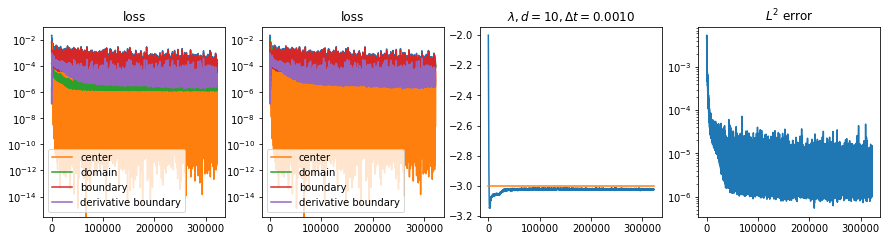

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

ax[0].plot(loss_log)
ax[0].plot(loss_log_center, label='center')
ax[0].plot(loss_log_domain, label='domain')
ax[0].plot(loss_log_boundary, label='boundary')
ax[0].plot(loss_log_derivative_boundary, label='derivative boundary')
ax[0].legend()
ax[0].set_yscale('log');
ax[0].set_title('loss')
ax[1].plot(loss_log)
ax[1].plot(np.array(loss_log_center), label='center')
ax[1].plot(alpha[0] * np.array(loss_log_domain), label='domain')
ax[1].plot(alpha[1] * np.array(loss_log_boundary), label='boundary')
ax[1].plot(alpha[1] * np.array(loss_log_derivative_boundary), label='derivative boundary')
ax[1].legend()
ax[1].set_yscale('log');
ax[1].set_title('loss')
ax[2].plot(lambda_log)
ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);
ax[2].set_title(r'$\lambda, d = %d, \Delta t = %.4f$' % (problem.d, delta_t));
ax[3].plot(V_L2_log)
ax[3].set_yscale('log');
ax[3].set_title(r'$L^2$ error');

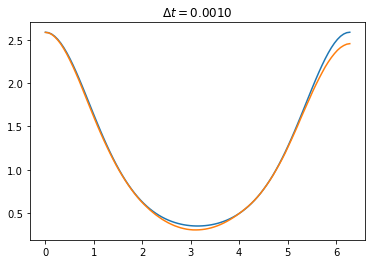

In [105]:
#X = pt.cat([pt.linspace(0, 1, 100).unsqueeze(1), pt.zeros(100, problem.d - 1)], 1).to(device)
plt.title(r'$\Delta t = %.4f$' % delta_t)
X = pt.linspace(0, 2 * np.pi, 100).unsqueeze(1).repeat(1, problem.d).to(device)
plt.plot(X[:, 0].squeeze().cpu().numpy(), problem.v_true(X.cpu()).numpy())
plt.plot(X[:, 0].squeeze().detach().cpu().numpy(), (V(X).squeeze().detach().cpu().numpy()));

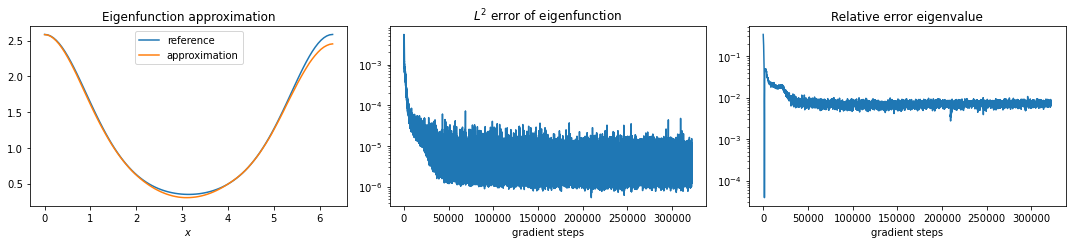

In [118]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

ax[0].set_title(r'Eigenfunction approximation')
X = pt.linspace(0, 2 * np.pi, 100).unsqueeze(1).repeat(1, problem.d).to(device)
ax[0].plot(X[:, 0].squeeze().cpu().numpy(), problem.v_true(X.cpu()).numpy(), label='reference')
ax[0].plot(X[:, 0].squeeze().detach().cpu().numpy(), (V(X).squeeze().detach().cpu().numpy()), label='approximation');
ax[0].set_xlabel(r'$x$')
ax[0].legend()

ax[1].plot(V_L2_log)
ax[1].set_yscale('log');
ax[1].set_title(r'$L^2$ error of eigenfunction');
ax[1].set_xlabel('gradient steps')

ax[2].set_title('Relative error eigenvalue')
#ax[2].plot([np.abs(np.mean(lambda_log[i:i + 200]) + 3) / 3 for i in range(len(lambda_log) - 200)])
ax[2].plot((np.abs(np.array(lambda_log) + 3) / 3))
ax[2].set_yscale('log')
ax[2].set_xlabel('gradient steps')

#ax[2].set_title('Relative error of Eigenvalue')
#ax[2].plot([np.abs(problem.lambda_ - np.mean(lambda_log[i:i + 1000])) / (1 + problem.lambda_) for i in range(len(lambda_log) - 1000)])
#ax[2].set_yscale('log')
#ax[2].plot([0, len(lambda_log)], [problem.lambda_, problem.lambda_]);

fig.tight_layout()
#fig.savefig('img/Fokker-Planck-eigenvalue-d10.pdf')